# Load FNC data

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import transformers
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Conv2D,MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, BatchNormalization, Input, Concatenate, GlobalMaxPooling1D
import requests
from tensorflow.keras import activations, optimizers, losses
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

## train data

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/train.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,Headline,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,unrelated,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,agree,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",unrelated,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,unrelated,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,disagree,"Fear not arachnophobes, the story of Bunbury's..."


In [ ]:
label_encoder = LabelEncoder()
label = df['Stance']
labels_encoded = label_encoder.fit_transform(label)
df['Stance'] = labels_encoded
df.head()

,Headline,Stance,articleBody
0,Police find mass graves with at least '15 bodi...,3,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,0,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",3,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,3,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1,"Fear not arachnophobes, the story of Bunbury's..."


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df, df['Stance'] = ros.fit_resample(df, df['Stance'])

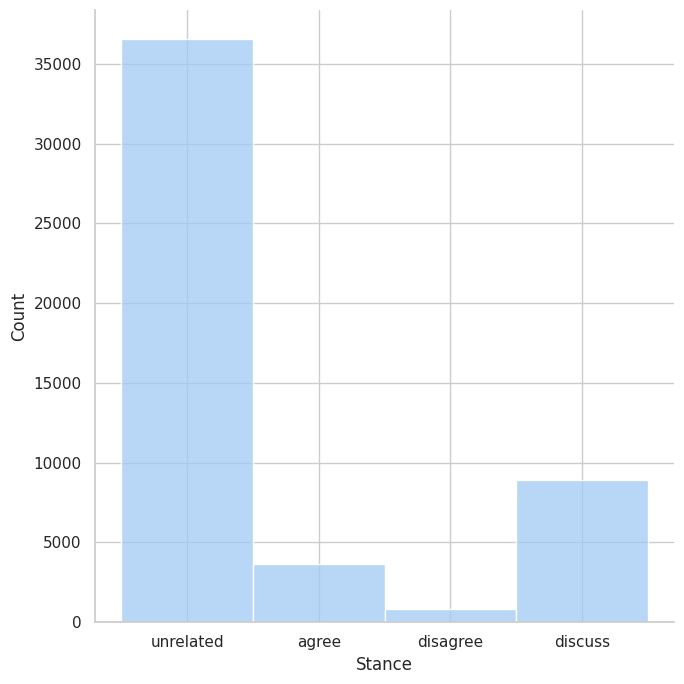

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df, x="Stance",height=7,aspect=1)

In [ ]:
df['Stance'] = df['Stance'].apply(lambda x: 1 if x.lower() in ['agree', 'discuss'] else 0)

## test data

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/test.csv'
df1 = pd.read_csv(path,delimiter=',')

In [ ]:
df1.head()

,Headline,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,unrelated,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,unrelated,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,unrelated,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",unrelated,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,unrelated,An airline passenger headed to Dallas was remo...


In [ ]:
label_encoder = LabelEncoder()
label = df1['Stance']
labels_encoded = label_encoder.fit_transform(label)
df1['Stance'] = labels_encoded
df1.head()

,Headline,Stance,articleBody
0,Ferguson riots: Pregnant woman loses eye after...,3,A RESPECTED senior French police officer inves...
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,3,Dave Morin's social networking company Path is...
2,A Russian Guy Says His Justin Bieber Ringtone ...,3,A bereaved Afghan mother took revenge on the T...
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",3,Hewlett-Packard is officially splitting in two...
4,Argentina's President Adopts Boy to End Werewo...,3,An airline passenger headed to Dallas was remo...


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df1, df1['Stance'] = ros.fit_resample(df1, df1['Stance'])

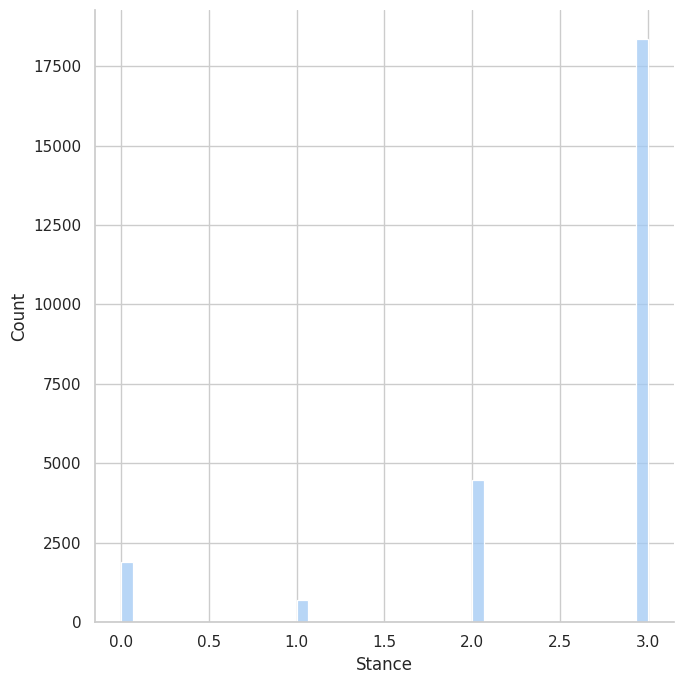

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df1, x="Stance",height=7,aspect=1)

# DistilBERT Train

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=4,output_hidden_states=True)

for layer in model_distil.layers[:-2]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_projector', 'vocab_transform', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
df['articleBody'] = df['articleBody'].astype(str)
df1['articleBody'] = df1['articleBody'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df['articleBody'].tolist(), truncation = True, padding = True  )

test_encodings = tokenizer_distil(df1['articleBody'].tolist(), truncation = True, padding = True  )


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df['Stance'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df1['Stance'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(3)
test_dataset = test_dataset.batch(3)

In [ ]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=2, epochs=2)

Epoch 1/2
16658/16658 [==============================] - 1279s 76ms/step - loss: 0.7908 - accuracy: 0.7313
Epoch 2/2
16658/16658 [==============================] - 1278s 77ms/step - loss: 0.7748 - accuracy: 0.7313


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=2)

8471/8471 [==============================] - 589s 69ms/step - loss: 0.8307 - accuracy: 0.7220


In [ ]:
model_distil.save_pretrained('/content/drive/MyDrive/FakeNewsChallenge/distil_article')

# DistilBERT Embeddings

In [ ]:
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

## DistilBERT train titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:32:27<00:00,  9.01it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert.npy', labels)

## DistilBERT test titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [47:52<00:00,  8.85it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert.npy', labels)

## DistilBERT train text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:39:22<00:00,  8.38it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert.npy', labels)

## DistilBERT test text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [51:03<00:00,  8.30it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert.npy', labels)

## DistilBERT train maxworth embeddings

In [ ]:
!pip install requests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import requests
import json
from tqdm import tqdm
def get_sentence_scores(sentences, api_key):
  api_endpoint = "https://idir.uta.edu/claimbuster/api/v2/score/text/sentences/"
  request_headers = {"x-api-key": api_key}
  payload = {"input_text": sentences}
  api_response = requests.post(url=api_endpoint, json=payload, headers=request_headers)
  return api_response.json()


In [ ]:
def max_worth(text,limit):
  api_key = '62ed42f8ab5d412facdc20e76e7dfe50'
  c = get_sentence_scores(text,api_key)
  c = sorted(c['results'], key=lambda x: float(x['score']), reverse=True)
  for res in c:
    res['word_count'] = len(res['text'].split())

  total_words = 0
  last_index = -1

  for i, item in enumerate(c):
    text = item['text']
    word_count = len(text.split())
    if total_words + word_count > 450:
      break
    total_words += word_count
    last_index = i

  c = c[:last_index+1]
  c = sorted(c, key=lambda x: x['index'])
  c = ' '.join([result['text'] for result in c])

  return c

In [ ]:
df['max'] = tqdm(df['articleBody'].apply(max_worth,limit=512))

100%|██████████| 49972/49972 [00:00<00:00, 437572.70it/s]


In [ ]:
df.to_csv('/content/drive/My Drive/FakeNewsChallenge/final_max.csv', index=False)

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
model_distil = TFDistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/FakeNewsChallenge/distil_article',num_labels=4,output_hidden_states=True)

Some layers from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_article were not used when initializing TFDistilBertForSequenceClassification: ['dropout_40']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_article and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inferen

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:34:39<00:00,  8.80it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_max_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_max_distilbert.npy', labels)

## DistilBERT test maxworth embeddings

In [ ]:
df1['max'] = tqdm(df1['articleBody'].apply(max_worth,limit=512))

100%|██████████| 25413/25413 [00:00<00:00, 993437.17it/s]


In [ ]:
df1.to_csv('/content/drive/My Drive/FakeNewsChallenge/final_max1.csv', index=False)

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max1.csv'
df1 = pd.read_csv(path,delimiter=',')

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles =str(titles[i:i+batch_size])
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [49:18<00:00,  8.59it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_max_distilbert.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_max_distilbert.npy', labels)

# **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([25413, 768, 1])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 30s 9ms/step - loss: 0.3616 - accuracy: 0.7310 - val_loss: 0.3627 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 31s 10ms/step - loss: 0.3553 - accuracy: 0.7313 - val_loss: 0.3640 - val_accuracy: 0.7220
Epoch 3/10
3124/3124 [==============================] - 21s 7ms/step - loss: 0.3527 - accuracy: 0.7313 - val_loss: 0.3668 - val_accuracy: 0.7220
Epoch 4/10
3124/3124 [==============================] - 21s 7ms/step - loss: 0.3510 - accuracy: 0.7313 - val_loss: 0.3609 - val_accuracy: 0.7220
Epoch 5/10
3124/3124 [==============================] - 20s 6ms/step - loss: 0.3453 - accuracy: 0.7313 - val_loss: 0.3598 - val_accuracy: 0.7220
Epoch 6/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.3415 - accuracy: 0.7313 - val_loss: 0.3610 - val_accuracy: 0.7220
Epoch 7/10
3124/3124 [==============================] - 20s 6ms/step - loss: 0.3389 - accuracy: 0.7313 - val_loss: 0.3682 - val_a

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7220320105552673
Test F1 Score: 0.2096453544170742
Test Recall: 0.25
Precision: 0.18050800771258804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 764, 128)          768       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 152, 128)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 flatten_3 (Flatten)         (None, 3200)             

795/795 [==============================] - 2s 2ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


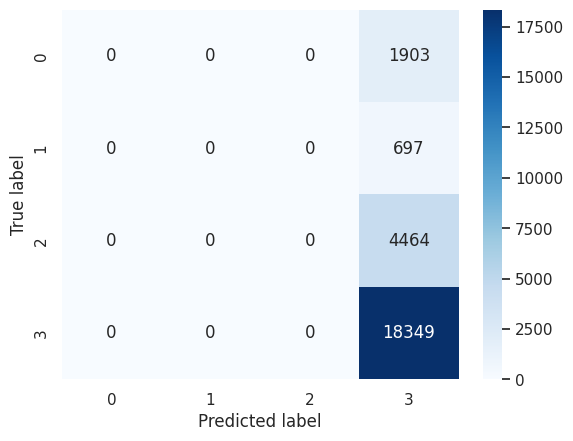

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print the classification report
    print(classification_report(a, y_pred))

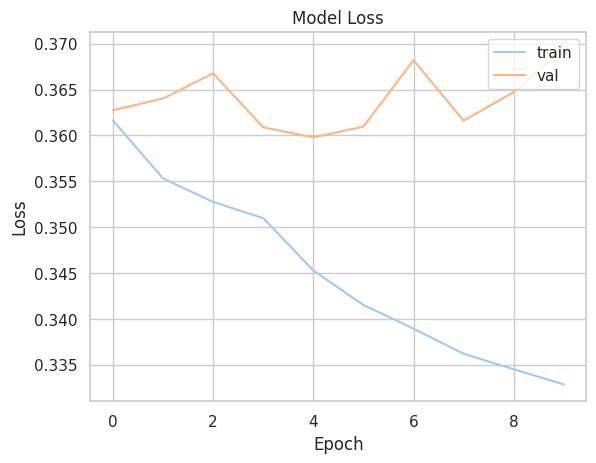

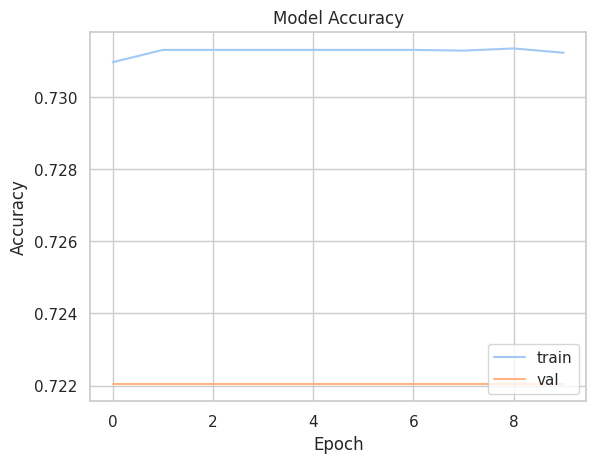

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.00      0.00      0.00      4464
           3       0.72      1.00      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.18      0.25      0.21     25413
weighted avg       0.52      0.72      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 51s 15ms/step - loss: 0.3656 - accuracy: 0.7312 - val_loss: 0.3698 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 46s 15ms/step - loss: 0.3416 - accuracy: 0.7313 - val_loss: 0.3622 - val_accuracy: 0.7220
Epoch 3/10
3124/3124 [==============================] - 47s 15ms/step - loss: 0.3367 - accuracy: 0.7313 - val_loss: 0.3629 - val_accuracy: 0.7212
Epoch 4/10
3124/3124 [==============================] - 47s 15ms/step - loss: 0.3335 - accuracy: 0.7313 - val_loss: 0.3798 - val_accuracy: 0.7220
Epoch 5/10
3124/3124 [==============================] - 45s 14ms/step - loss: 0.3312 - accuracy: 0.7314 - val_loss: 0.3692 - val_accuracy: 0.7220
Epoch 6/10
3124/3124 [==============================] - 48s 15ms/step - loss: 0.3284 - accuracy: 0.7310 - val_loss: 0.3753 - val_accuracy: 0.7220
Epoch 7/10
3124/3124 [==============================] - 46s 15ms/step - loss: 0.3262 - accuracy: 0.7307 - val_loss: 0.3683 -

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.7220320105552673
Test F1 Score: 0.2096453544170742
Test Recall: 0.25
Precision: 0.18050800771258804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_14 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm_1 (LSTM)               (None, 185, 64)          

795/795 [==============================] - 5s 6ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


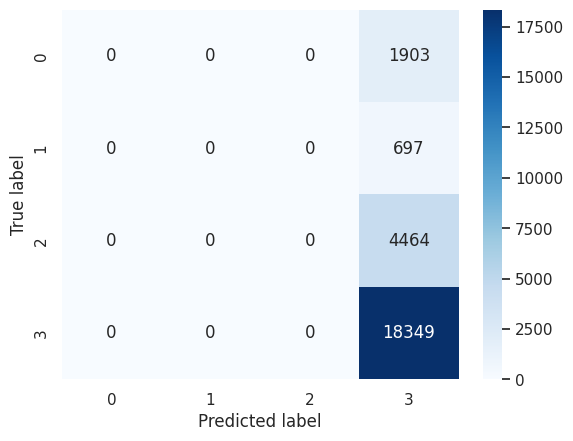

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

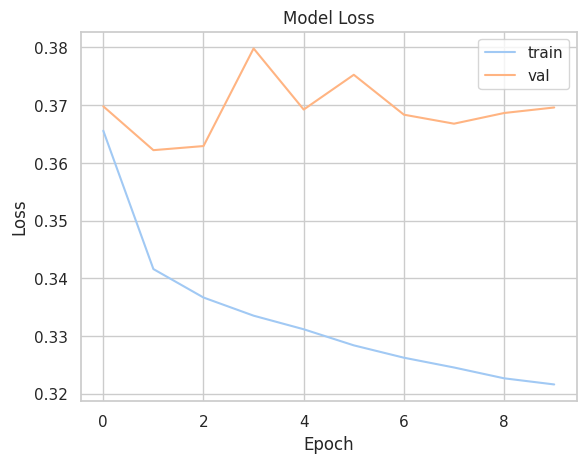

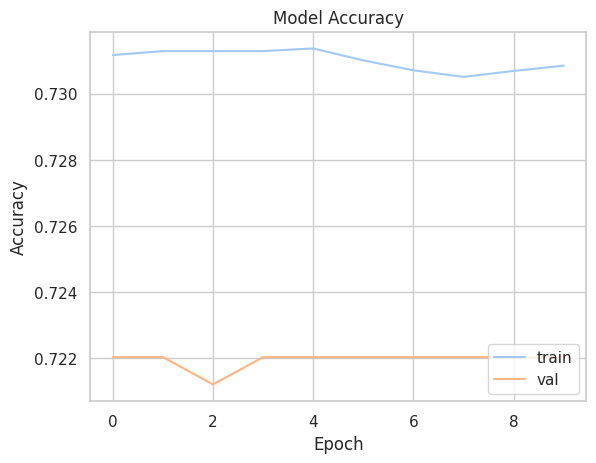

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.00      0.00      0.00      4464
           3       0.72      1.00      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.18      0.25      0.21     25413
weighted avg       0.52      0.72      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(4, activation='softmax')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 43s 13ms/step - loss: 0.3545 - accuracy: 0.7308 - val_loss: 0.3746 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 42s 14ms/step - loss: 0.3405 - accuracy: 0.7313 - val_loss: 0.3617 - val_accuracy: 0.7220
Epoch 3/10
3124/3124 [==============================] - 39s 12ms/step - loss: 0.3344 - accuracy: 0.7312 - val_loss: 0.3739 - val_accuracy: 0.7220
Epoch 4/10
3124/3124 [==============================] - 39s 13ms/step - loss: 0.3298 - accuracy: 0.7313 - val_loss: 0.3668 - val_accuracy: 0.7220
Epoch 5/10
3124/3124 [==============================] - 44s 14ms/step - loss: 0.3265 - accuracy: 0.7313 - val_loss: 0.3721 - val_accuracy: 0.7220
Epoch 6/10
3124/3124 [==============================] - 40s 13ms/step - loss: 0.3240 - accuracy: 0.7310 - val_loss: 0.3707 - val_accuracy: 0.7220
Epoch 7/10
3124/3124 [==============================] - 39s 13ms/step - loss: 0.3217 - accuracy: 0.7307 - val_loss: 0.3703 -

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.7220320105552673
Test F1 Score: 0.2096453544170742
Test Recall: 0.25
Precision: 0.18050800771258804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


795/795 [==============================] - 4s 5ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


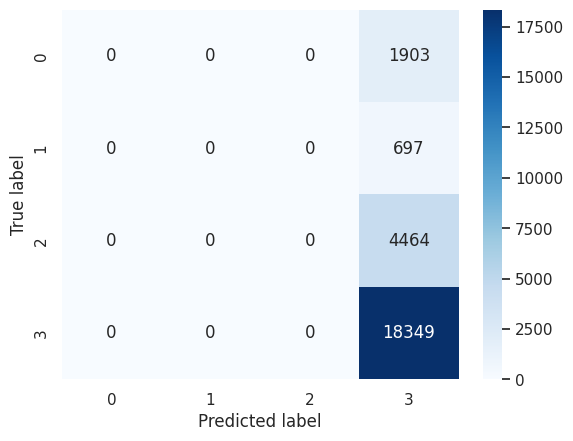

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **CNN-DistilBERT-Titles-Short**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([3360, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([2788, 768, 1])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
210/210 [==============================] - 4s 9ms/step - loss: 0.5809 - accuracy: 0.2542 - val_loss: 0.5622 - val_accuracy: 0.2873
Epoch 2/10
210/210 [==============================] - 2s 7ms/step - loss: 0.5613 - accuracy: 0.3140 - val_loss: 0.5535 - val_accuracy: 0.3103
Epoch 3/10
210/210 [==============================] - 2s 7ms/step - loss: 0.5463 - accuracy: 0.3634 - val_loss: 0.5543 - val_accuracy: 0.3038
Epoch 4/10
210/210 [==============================] - 2s 9ms/step - loss: 0.5311 - accuracy: 0.4113 - val_loss: 0.5591 - val_accuracy: 0.3103
Epoch 5/10
210/210 [==============================] - 2s 10ms/step - loss: 0.5148 - accuracy: 0.4324 - val_loss: 0.5618 - val_accuracy: 0.3171
Epoch 6/10
210/210 [==============================] - 2s 10ms/step - loss: 0.4986 - accuracy: 0.4744 - val_loss: 0.5837 - val_accuracy: 0.3138
Epoch 7/10
210/210 [==============================] - 2s 8ms/step - loss: 0.4796 - accuracy: 0.4946 - val_loss: 0.6085 - val_accuracy: 0.3095
Epoc

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

88/88 [==============================] - 0s 2ms/step
Test Accuracy: 0.3224533796310425
Test F1 Score: 0.3040102286604466
Test Recall: 0.32245337159253945
Precision: 0.3216838525928066


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 flatten_6 (Flatten)         (None, 3200)             

88/88 [==============================] - 0s 3ms/step
[[273 108 188 128]
 [218 126 181 172]
 [153  21 393 130]
 [195  56 339 107]]


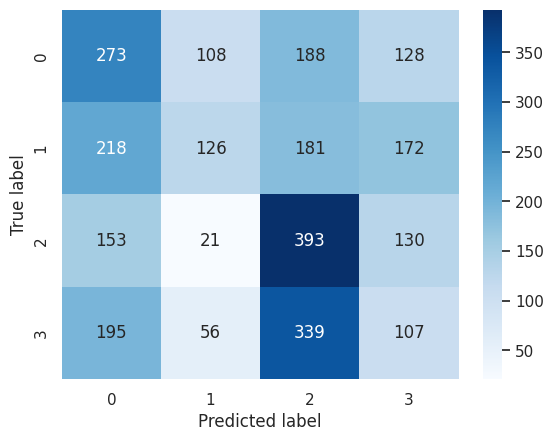

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print the classification report
    print(classification_report(a, y_pred))

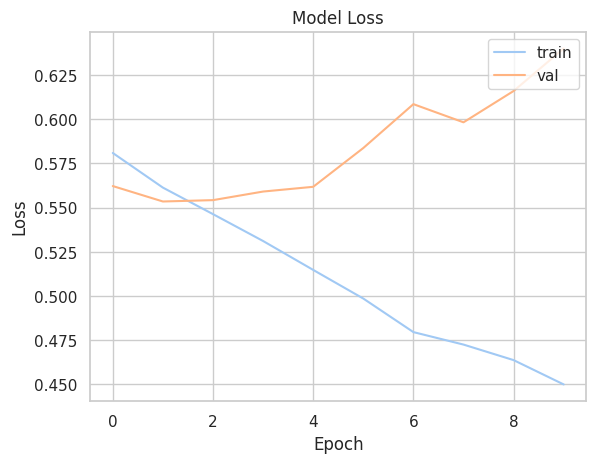

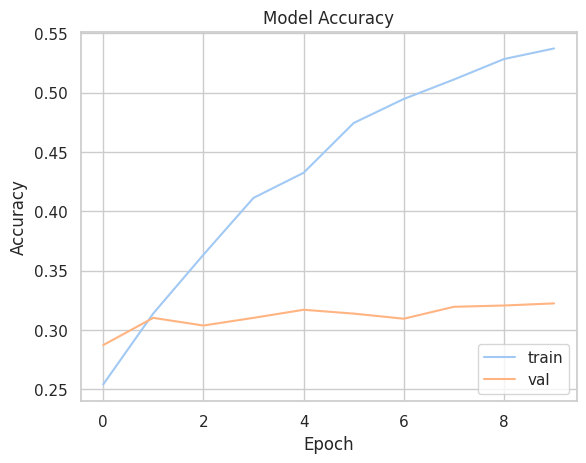

              precision    recall  f1-score   support

           0       0.33      0.39      0.36       697
           1       0.41      0.18      0.25       697
           2       0.36      0.56      0.44       697
           3       0.20      0.15      0.17       697

    accuracy                           0.32      2788
   macro avg       0.32      0.32      0.30      2788
weighted avg       0.32      0.32      0.30      2788



In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Titles-Short**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
210/210 [==============================] - 10s 21ms/step - loss: 0.7788 - accuracy: 0.3202 - val_loss: 0.6953 - val_accuracy: 0.3192
Epoch 2/10
210/210 [==============================] - 4s 19ms/step - loss: 0.5484 - accuracy: 0.3932 - val_loss: 0.6284 - val_accuracy: 0.3052
Epoch 3/10
210/210 [==============================] - 6s 29ms/step - loss: 0.5197 - accuracy: 0.4378 - val_loss: 0.6573 - val_accuracy: 0.2511
Epoch 4/10
210/210 [==============================] - 3s 17ms/step - loss: 0.5022 - accuracy: 0.4640 - val_loss: 0.5823 - val_accuracy: 0.3067
Epoch 5/10
210/210 [==============================] - 3s 17ms/step - loss: 0.4897 - accuracy: 0.4899 - val_loss: 0.5933 - val_accuracy: 0.3060
Epoch 6/10
210/210 [==============================] - 5s 24ms/step - loss: 0.4773 - accuracy: 0.5208 - val_loss: 0.6169 - val_accuracy: 0.2963
Epoch 7/10
210/210 [==============================] - 4s 21ms/step - loss: 0.4678 - accuracy: 0.5253 - val_loss: 0.6510 - val_accuracy: 0.321

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

88/88 [==============================] - 1s 8ms/step
Test Accuracy: 0.2966284155845642
Test F1 Score: 0.29157883206075924
Test Recall: 0.2966284074605452
Precision: 0.3123480476515412


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_22 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 382, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 189, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm_2 (LSTM)               (None, 185, 64)          

88/88 [==============================] - 1s 8ms/step
[[275 104  74 244]
 [301 129  63 204]
 [201  67 172 257]
 [209  93 144 251]]


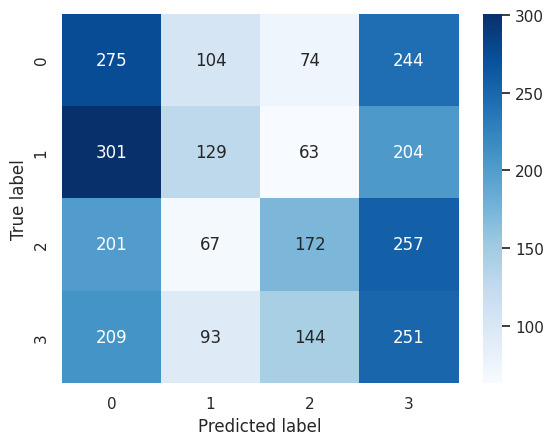

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

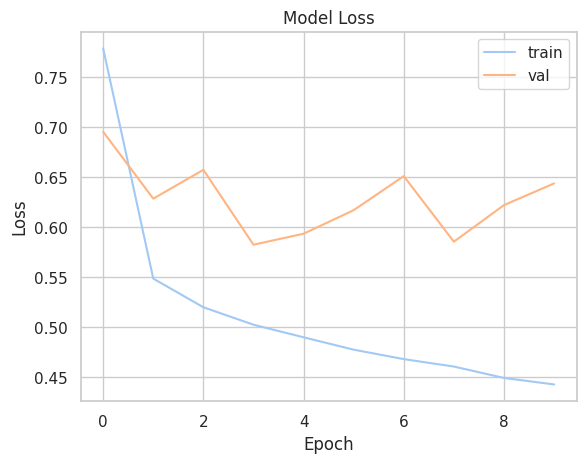

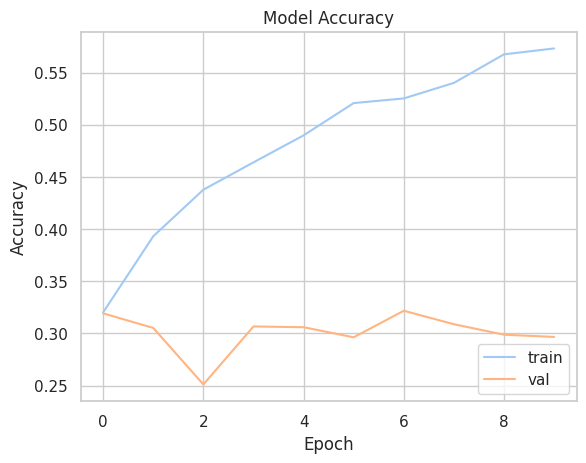

              precision    recall  f1-score   support

           0       0.28      0.39      0.33       697
           1       0.33      0.19      0.24       697
           2       0.38      0.25      0.30       697
           3       0.26      0.36      0.30       697

    accuracy                           0.30      2788
   macro avg       0.31      0.30      0.29      2788
weighted avg       0.31      0.30      0.29      2788



In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Titles-Short**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(4, activation='softmax')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
210/210 [==============================] - 18s 17ms/step - loss: 0.5770 - accuracy: 0.2628 - val_loss: 0.5585 - val_accuracy: 0.3092
Epoch 2/10
210/210 [==============================] - 3s 14ms/step - loss: 0.5480 - accuracy: 0.3729 - val_loss: 0.5534 - val_accuracy: 0.3311
Epoch 3/10
210/210 [==============================] - 3s 13ms/step - loss: 0.5216 - accuracy: 0.4351 - val_loss: 0.5552 - val_accuracy: 0.3253
Epoch 4/10
210/210 [==============================] - 3s 12ms/step - loss: 0.4965 - accuracy: 0.4810 - val_loss: 0.5634 - val_accuracy: 0.3210
Epoch 5/10
210/210 [==============================] - 3s 15ms/step - loss: 0.4758 - accuracy: 0.4976 - val_loss: 0.6041 - val_accuracy: 0.3121
Epoch 6/10
210/210 [==============================] - 3s 12ms/step - loss: 0.4631 - accuracy: 0.5298 - val_loss: 0.6270 - val_accuracy: 0.3070
Epoch 7/10
210/210 [==============================] - 3s 14ms/step - loss: 0.4460 - accuracy: 0.5479 - val_loss: 0.6035 - val_accuracy: 0.312

In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

88/88 [==============================] - 1s 5ms/step
Test Accuracy: 0.30918219685554504
Test F1 Score: 0.3012308678730856
Test Recall: 0.30918220946915353
Precision: 0.3279762581774265


88/88 [==============================] - 0s 5ms/step
[[358 123  66 150]
 [374 142  49 132]
 [268  53 187 189]
 [282  90 150 175]]


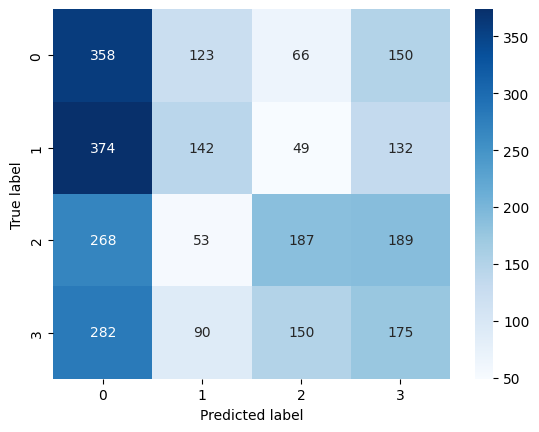

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **CNN-DistilBERT-Texts**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([25413, 768, 1])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
from tensorflow.keras.regularizers import l2
# build the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(768,1),kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Flatten())
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 121s 38ms/step - loss: 0.3945 - accuracy: 0.7308 - val_loss: 0.3638 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 117s 38ms/step - loss: 0.3557 - accuracy: 0.7313 - val_loss: 0.3627 - val_accuracy: 0.7220
Epoch 3/10
3124/3124 [==============================] - 123s 39ms/step - loss: 0.3520 - accuracy: 0.7313 - val_loss: 0.3630 - val_accuracy: 0.7220
Epoch 4/10
3124/3124 [==============================] - 113s 36ms/step - loss: 0.3509 - accuracy: 0.7313 - val_loss: 0.3630 - val_accuracy: 0.7220
Epoch 5/10
3124/3124 [==============================] - 109s 35ms/step - loss: 0.3506 - accuracy: 0.7313 - val_loss: 0.3624 - val_accuracy: 0.7220
Epoch 6/10
3124/3124 [==============================] - 117s 38ms/step - loss: 0.3503 - accuracy: 0.7313 - val_loss: 0.3624 - val_accuracy: 0.7220
Epoch 7/10
3124/3124 [==============================] - 118s 38ms/step - loss: 0.3501 - accuracy: 0.7313 - val_loss: 0

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 12s 15ms/step
Test Accuracy: 0.7220320105552673
Test F1 Score: 0.2096453544170742
Test Recall: 0.25
Precision: 0.18050800771258804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 152, 64)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 148, 64)           20544     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 25, 64)            20544     
                                                                 
 flatten_3 (Flatten)         (None, 1600)             

795/795 [==============================] - 11s 14ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


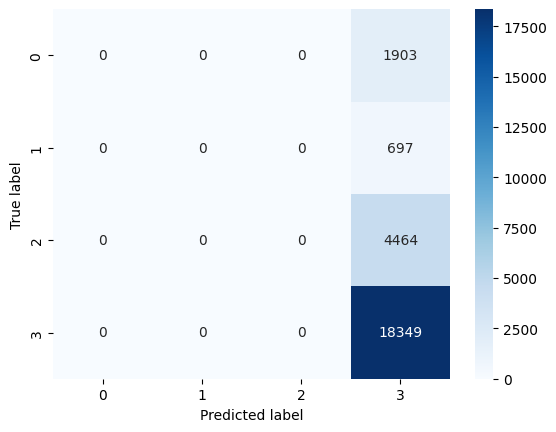

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print the classification report
    print(classification_report(a, y_pred))

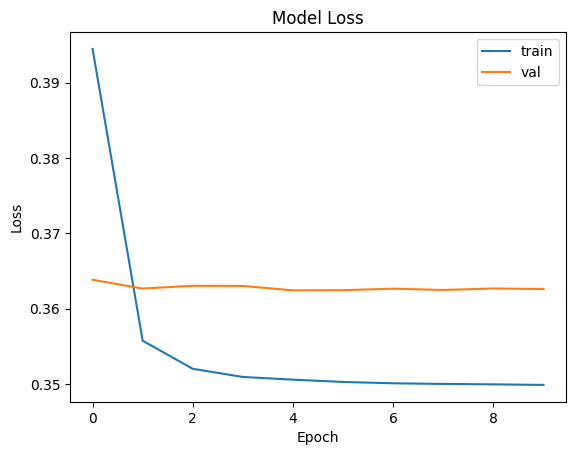

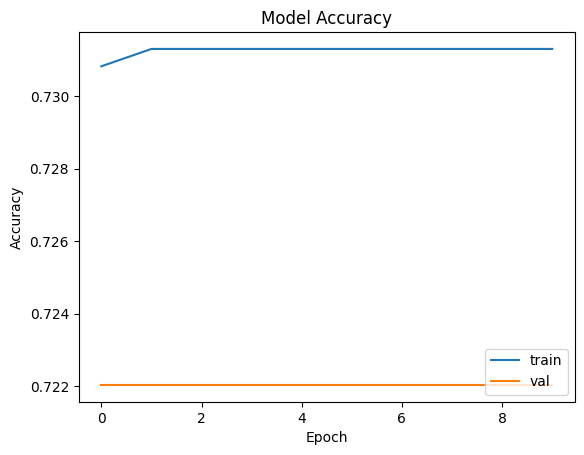

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.00      0.00      0.00      4464
           3       0.72      1.00      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.18      0.25      0.21     25413
weighted avg       0.52      0.72      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Texts**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 56s 16ms/step - loss: 0.3565 - accuracy: 0.7304 - val_loss: 0.3763 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 47s 15ms/step - loss: 0.3230 - accuracy: 0.7337 - val_loss: 0.3695 - val_accuracy: 0.7143
Epoch 3/10
3124/3124 [==============================] - 47s 15ms/step - loss: 0.3111 - accuracy: 0.7406 - val_loss: 0.3922 - val_accuracy: 0.7185
Epoch 4/10
3124/3124 [==============================] - 45s 15ms/step - loss: 0.2995 - accuracy: 0.7492 - val_loss: 0.3967 - val_accuracy: 0.6985
Epoch 5/10
3124/3124 [==============================] - 45s 15ms/step - loss: 0.2884 - accuracy: 0.7597 - val_loss: 0.3875 - val_accuracy: 0.7066
Epoch 6/10
3124/3124 [==============================] - 45s 15ms/step - loss: 0.2799 - accuracy: 0.7697 - val_loss: 0.3971 - val_accuracy: 0.6753
Epoch 7/10
3124/3124 [==============================] - 46s 15ms/step - loss: 0.2735 - accuracy: 0.7748 - val_loss: 0.4188 -

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 6s 7ms/step
Test Accuracy: 0.6196041107177734
Test F1 Score: 0.27020998925705875
Test Recall: 0.2725148779977487
Precision: 0.2716720507481385


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 764, 64)           384       
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm (LSTM)                 (None, 185, 64)          

795/795 [==============================] - 4s 5ms/step
[[  207     0   112  1584]
 [   81     0    36   580]
 [  112     0   793  3559]
 [ 1230     0  2373 14746]]


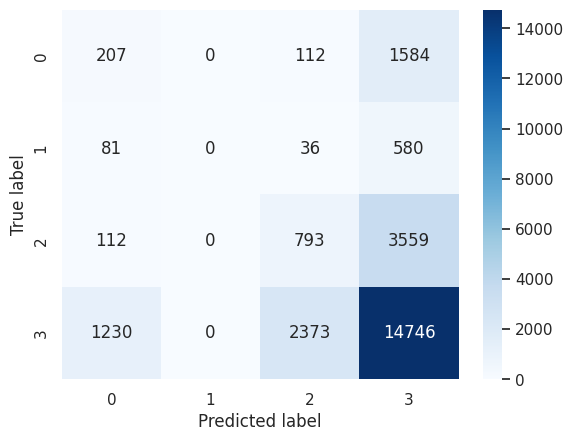

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

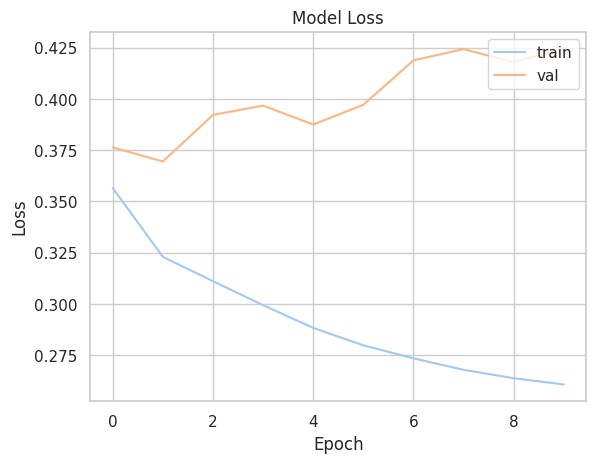

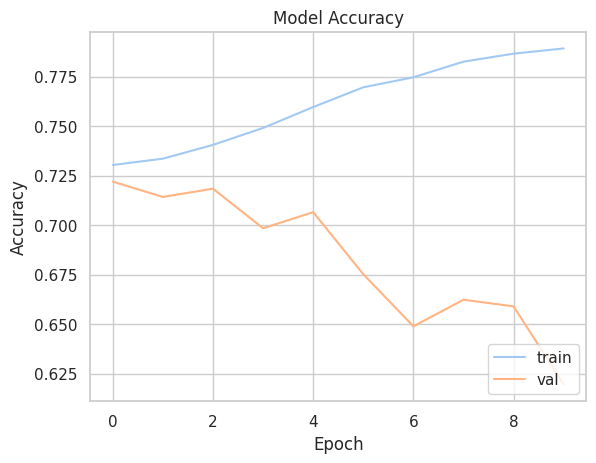

              precision    recall  f1-score   support

           0       0.13      0.11      0.12      1903
           1       0.00      0.00      0.00       697
           2       0.24      0.18      0.20      4464
           3       0.72      0.80      0.76     18349

    accuracy                           0.62     25413
   macro avg       0.27      0.27      0.27     25413
weighted avg       0.57      0.62      0.59     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Texts**


In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(4, activation='softmax')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=2, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/2
3124/3124 [==============================] - 1687s 540ms/step - loss: 0.2558 - accuracy: 0.7901 - val_loss: 0.4387 - val_accuracy: 0.6511
Epoch 2/2
3124/3124 [==============================] - 1690s 541ms/step - loss: 0.2528 - accuracy: 0.7951 - val_loss: 0.4490 - val_accuracy: 0.5971


In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 147s 185ms/step
Test Accuracy: 0.5970959663391113
Test F1 Score: 0.24257223046890883
Test Recall: 0.2463567804268531
Precision: 0.2581216570194278


795/795 [==============================] - 148s 187ms/step
[[  166     3   158  1576]
 [   25     4    54   614]
 [  200     2   441  3821]
 [ 1112    41  2633 14563]]


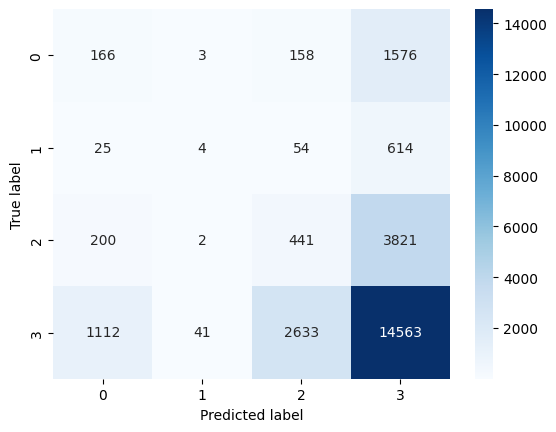

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **CNN-DistilBERT-MaxWorth**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_max_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_max_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_max_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_max_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([25413, 768, 1])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
from tensorflow.keras.regularizers import l2
# build the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(768,1),kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(64, 5, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Flatten())
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=10, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 33s 8ms/step - loss: 0.3954 - accuracy: 0.7285 - val_loss: 0.3645 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.3557 - accuracy: 0.7313 - val_loss: 0.3629 - val_accuracy: 0.7220
Epoch 3/10
3124/3124 [==============================] - 24s 8ms/step - loss: 0.3522 - accuracy: 0.7313 - val_loss: 0.3624 - val_accuracy: 0.7220
Epoch 4/10
3124/3124 [==============================] - 22s 7ms/step - loss: 0.3511 - accuracy: 0.7313 - val_loss: 0.3627 - val_accuracy: 0.7220
Epoch 5/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.3506 - accuracy: 0.7313 - val_loss: 0.3627 - val_accuracy: 0.7220
Epoch 6/10
3124/3124 [==============================] - 21s 7ms/step - loss: 0.3503 - accuracy: 0.7313 - val_loss: 0.3626 - val_accuracy: 0.7220
Epoch 7/10
3124/3124 [==============================] - 23s 7ms/step - loss: 0.3502 - accuracy: 0.7313 - val_loss: 0.3625 - val_ac

In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7220320105552673
Test F1 Score: 0.2096453544170742
Test Recall: 0.25
Precision: 0.18050800771258804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 64)           384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 64)           20544     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 64)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 64)            20544     
                                                                 
 flatten (Flatten)           (None, 1600)              0

795/795 [==============================] - 1s 2ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


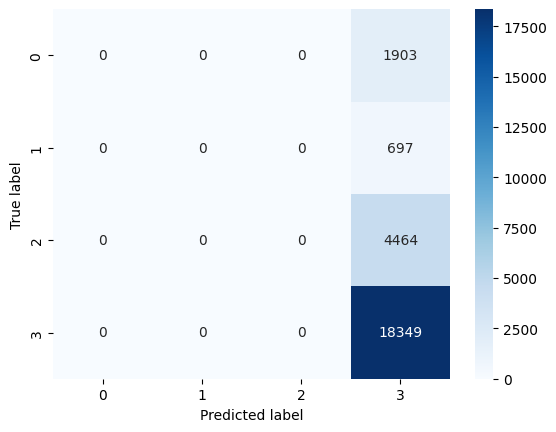

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()
    
    # Print the classification report
    print(classification_report(a, y_pred))

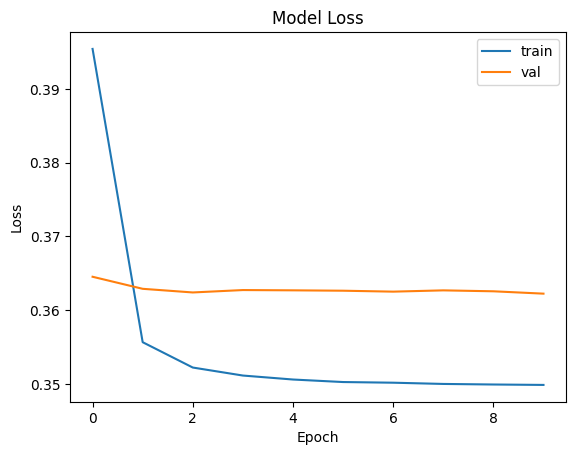

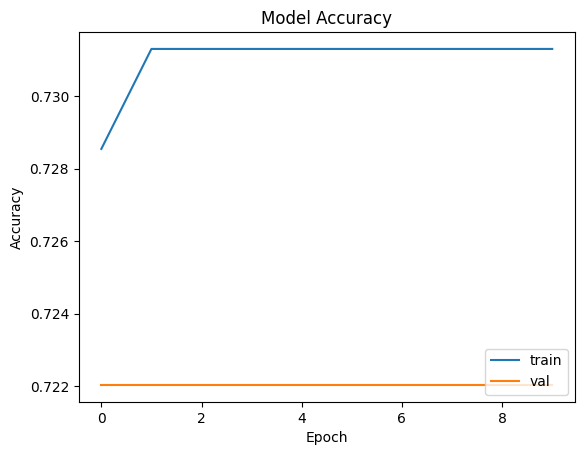

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1903
           1       0.00      0.00      0.00       697
           2       0.00      0.00      0.00      4464
           3       0.72      1.00      0.84     18349

    accuracy                           0.72     25413
   macro avg       0.18      0.25      0.21     25413
weighted avg       0.52      0.72      0.61     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-MaxWorth**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=10, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/10
3124/3124 [==============================] - 55s 16ms/step - loss: 0.3579 - accuracy: 0.7316 - val_loss: 0.3643 - val_accuracy: 0.7220
Epoch 2/10
3124/3124 [==============================] - 50s 16ms/step - loss: 0.3262 - accuracy: 0.7357 - val_loss: 0.3776 - val_accuracy: 0.7220
Epoch 3/10
3124/3124 [==============================] - 49s 16ms/step - loss: 0.3156 - accuracy: 0.7405 - val_loss: 0.3740 - val_accuracy: 0.7106
Epoch 4/10
3124/3124 [==============================] - 46s 15ms/step - loss: 0.3059 - accuracy: 0.7453 - val_loss: 0.4027 - val_accuracy: 0.7173
Epoch 5/10
3124/3124 [==============================] - 47s 15ms/step - loss: 0.2993 - accuracy: 0.7522 - val_loss: 0.3958 - val_accuracy: 0.6801
Epoch 6/10
3124/3124 [==============================] - 50s 16ms/step - loss: 0.2939 - accuracy: 0.7568 - val_loss: 0.4025 - val_accuracy: 0.6686
Epoch 7/10
3124/3124 [==============================] - 47s 15ms/step - loss: 0.2887 - accuracy: 0.7614 - val_loss: 0.4208 -

In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels)

y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 5s 6ms/step
Test Accuracy: 0.6368393898010254
Test F1 Score: 0.25475645596680097
Test Recall: 0.25968232431087224
Precision: 0.25942347170478325


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 764, 64)           384       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 378, 64)           20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 lstm (LSTM)                 (None, 185, 64)          

795/795 [==============================] - 4s 5ms/step
[[  106     0   116  1681]
 [   26     0    46   625]
 [  109     0   630  3725]
 [  916     0  1985 15448]]


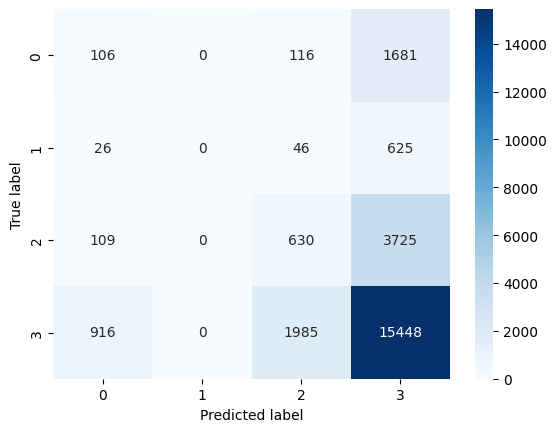

In [ ]:
y_pred = model2.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

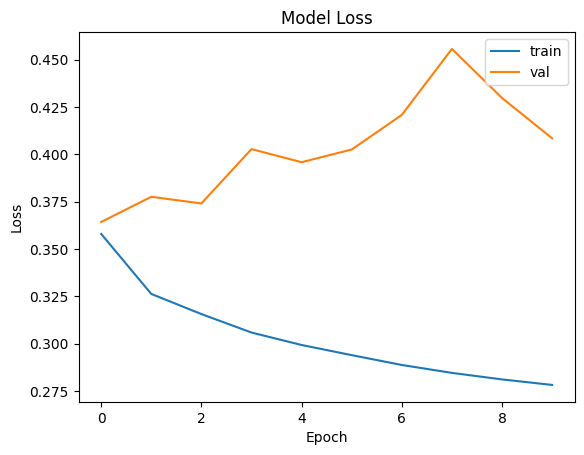

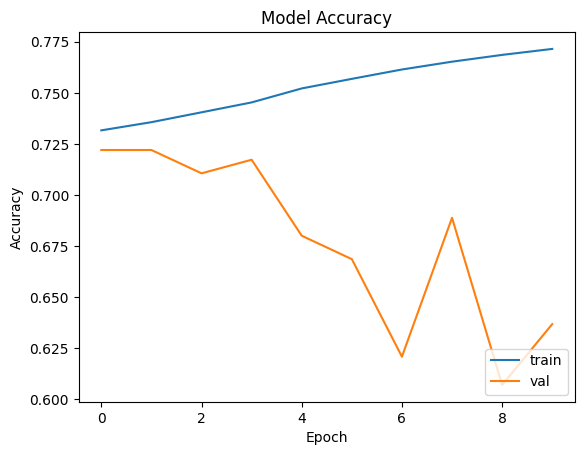

              precision    recall  f1-score   support

           0       0.09      0.06      0.07      1903
           1       0.00      0.00      0.00       697
           2       0.23      0.14      0.17      4464
           3       0.72      0.84      0.78     18349

    accuracy                           0.64     25413
   macro avg       0.26      0.26      0.25     25413
weighted avg       0.57      0.64      0.60     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-MaxWorth**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(4, activation='softmax')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=2, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/2
3124/3124 [==============================] - 56s 12ms/step - loss: 0.3567 - accuracy: 0.7307 - val_loss: 0.3631 - val_accuracy: 0.7220
Epoch 2/2
3124/3124 [==============================] - 42s 13ms/step - loss: 0.3399 - accuracy: 0.7313 - val_loss: 0.3609 - val_accuracy: 0.7220


In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels)

y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)



f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.7220320105552673
Test F1 Score: 0.2096453544170742
Test Recall: 0.25
Precision: 0.18050800771258804


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


795/795 [==============================] - 4s 5ms/step
[[    0     0     0  1903]
 [    0     0     0   697]
 [    0     0     0  4464]
 [    0     0     0 18349]]


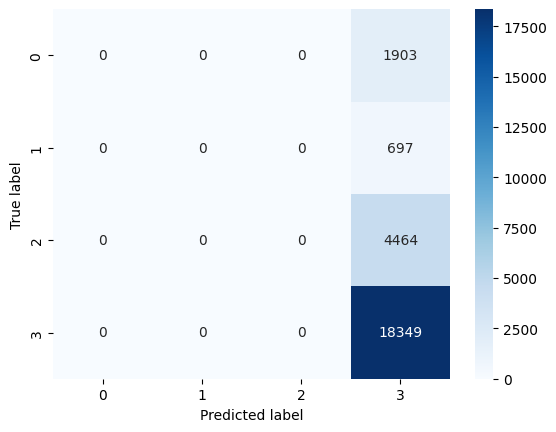

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **DistilBERT-Text-Title**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([49972, 768, 1])

In [ ]:
test_embeddings1.shape

TensorShape([25413, 768, 1])

In [ ]:
train_labels1 = to_categorical(train_labels1, num_classes=4)
test_labels1 = to_categorical(test_labels1, num_classes=4)

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([25413, 768, 1])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(4, activation='softmax', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 18s 4ms/step - loss: 0.3345 - accuracy: 0.7310
Epoch 2/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.3204 - accuracy: 0.7335
Epoch 3/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.3129 - accuracy: 0.7360
Epoch 4/9
3124/3124 [==============================] - 15s 5ms/step - loss: 0.3077 - accuracy: 0.7385
Epoch 5/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.3025 - accuracy: 0.7410
Epoch 6/9
3124/3124 [==============================] - 10s 3ms/step - loss: 0.2972 - accuracy: 0.7459
Epoch 7/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.2926 - accuracy: 0.7486
Epoch 8/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.2897 - accuracy: 0.7507
Epoch 9/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.2859 - accuracy: 0.7529


In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 - 2s - loss: 0.3892 - accuracy: 0.7181 - 2s/epoch - 2ms/step
795/795 [==============================] - 1s 2ms/step
Test Accuracy: 0.7180970311164856
Test F1 Score: 0.21598761981943912
Test Recall: 0.2516893052917806
Precision: 0.28355018262016174


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense[0][0]',              

795/795 [==============================] - 3s 3ms/step
[[   18     0     2  1883]
 [   17     0     2   678]
 [    7     0    22  4435]
 [   30     0   110 18209]]


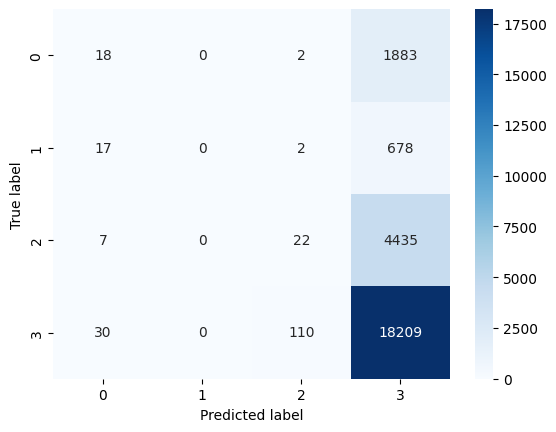

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **DistilBERT-MaxWorth-Title**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_max_distilbert.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_max_distilbert.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_max_distilbert.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_max_distilbert.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([49972, 768, 1])

In [ ]:
test_embeddings1.shape

TensorShape([25413, 768, 1])

In [ ]:
train_labels1 = to_categorical(train_labels1, num_classes=4)
test_labels1 = to_categorical(test_labels1, num_classes=4)

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
test_embeddings.shape

TensorShape([25413, 768, 1])

In [ ]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(4, activation='softmax', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.3335 - accuracy: 0.7321
Epoch 2/9
3124/3124 [==============================] - 11s 3ms/step - loss: 0.3193 - accuracy: 0.7360
Epoch 3/9
3124/3124 [==============================] - 11s 3ms/step - loss: 0.3110 - accuracy: 0.7367
Epoch 4/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.3050 - accuracy: 0.7405
Epoch 5/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.2997 - accuracy: 0.7433
Epoch 6/9
3124/3124 [==============================] - 11s 4ms/step - loss: 0.2938 - accuracy: 0.7477
Epoch 7/9
3124/3124 [==============================] - 11s 4ms/step - loss: 0.2907 - accuracy: 0.7504
Epoch 8/9
3124/3124 [==============================] - 11s 4ms/step - loss: 0.2876 - accuracy: 0.7515
Epoch 9/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.2837 - accuracy: 0.7562


In [ ]:
a = np.asarray(test_labels).argmax(axis=1)

In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)

f1 = f1_score(a,y_pred,average='macro')
recall = recall_score(a, y_pred,average='macro')
precision = precision_score(a, y_pred,average='macro')

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 - 2s - loss: 0.3800 - accuracy: 0.7217 - 2s/epoch - 2ms/step
795/795 [==============================] - 1s 2ms/step
Test Accuracy: 0.7217172384262085
Test F1 Score: 0.23997861145096905
Test Recall: 0.2631045666448396
Precision: 0.38040443008837355


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_1[0][0]',          

795/795 [==============================] - 1s 2ms/step
[[   28     0    11  1864]
 [   18     0     2   677]
 [    7     0   234  4223]
 [   39     0   231 18079]]


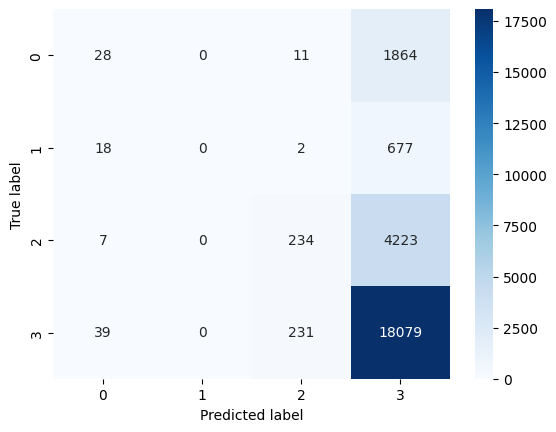

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = y_pred.argmax(axis=1)
cm = confusion_matrix(a, y_pred)
print(cm)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# **Binary**

## **train data**

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max.csv'
df = pd.read_csv(path,delimiter=',')

In [ ]:
df.head()

,Headline,Stance,articleBody,max
0,Police find mass graves with at least '15 bodi...,3,Danny Boyle is directing the untitled film\n\n...,Danny Boyle is directing the untitled film\n\n...
1,Hundreds of Palestinians flee floods in Gaza a...,0,Hundreds of Palestinians were evacuated from t...,Hundreds of Palestinians were evacuated from t...
2,"Christian Bale passes on role of Steve Jobs, a...",3,30-year-old Moscow resident was hospitalized w...,30-year-old Moscow resident was hospitalized w...
3,HBO and Apple in Talks for $15/Month Apple TV ...,3,(Reuters) - A Canadian soldier was shot at the...,(Reuters) - A Canadian soldier was shot at the...
4,Spider burrowed through tourist's stomach and ...,1,"Fear not arachnophobes, the story of Bunbury's...",Perth scientists have cast doubt over claims t...


In [ ]:
df['Stance'] = df['Stance'].apply(lambda x: 1 if x in [0, 2] else 0)

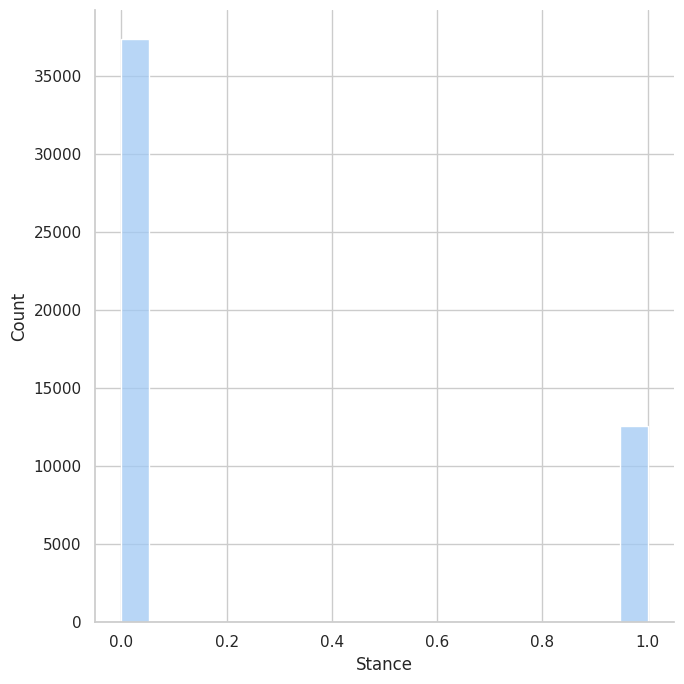

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df, x="Stance",height=7,aspect=1)

## **test data**

In [ ]:
path = '/content/drive/MyDrive/FakeNewsChallenge/final_max1.csv'
df1 = pd.read_csv(path,delimiter=',')

In [ ]:
df1['Stance'] = df1['Stance'].apply(lambda x: 1 if x in [0, 2] else 0)

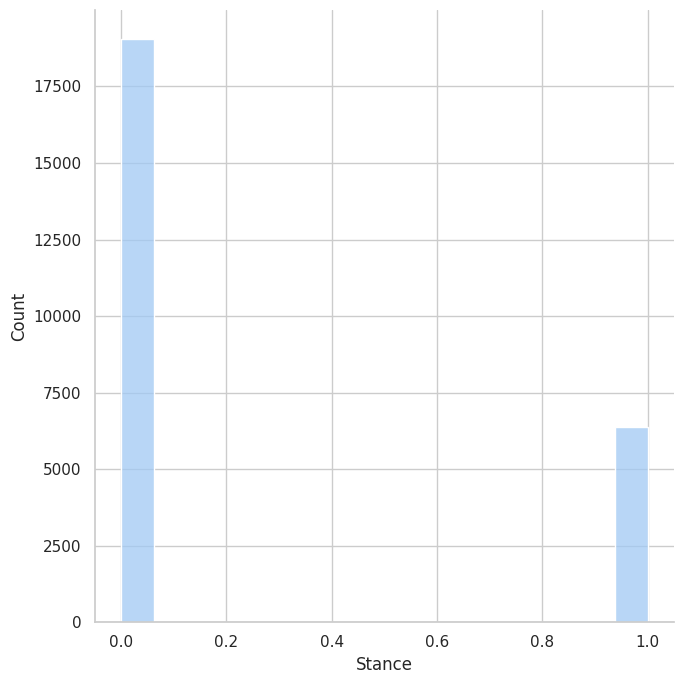

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df1, x="Stance",height=7,aspect=1)

## **DistilBERT Train**

In [ ]:
tokenizer_distil = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',padding=True, truncation=True, return_tensors='tf',add_special_tokens=True)
model_distil = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels=2,output_hidden_states=True)

for layer in model_distil.layers[:-2]:
    layer.trainable = False

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [ ]:
df['articleBody'] = df['articleBody'].astype(str)
df1['articleBody'] = df1['articleBody'].astype(str)

In [ ]:
train_encodings = tokenizer_distil(df['articleBody'].tolist(), truncation = True, padding = True  )

test_encodings = tokenizer_distil(df1['articleBody'].tolist(), truncation = True, padding = True  )


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df['Stance'].tolist()
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df1['Stance'].tolist()
))

In [ ]:
train_dataset = train_dataset.batch(2)
test_dataset = test_dataset.batch(2)

In [ ]:
optimizer = optimizers.Adam(learning_rate=3e-5)
loss = losses.SparseCategoricalCrossentropy(from_logits=True)
model_distil.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model_distil.fit(train_dataset, batch_size=2, epochs=2)

Epoch 1/2
24986/24986 [==============================] - 1407s 56ms/step - loss: 0.5588 - accuracy: 0.7481
Epoch 2/2
24986/24986 [==============================] - 1393s 56ms/step - loss: 0.5509 - accuracy: 0.7481


In [ ]:
benchmarks = model_distil.evaluate(test_dataset, return_dict=True, batch_size=2)

12707/12707 [==============================] - 635s 50ms/step - loss: 0.5701 - accuracy: 0.7495


In [ ]:
model_distil.save_pretrained('/content/drive/MyDrive/FakeNewsChallenge/distil_binary_text')

## **DistilBERT Embeddings**

In [ ]:
def get_embeddings(texts):
    encoded = tokenizer_distil(
      texts,
      add_special_tokens=True,
      padding=True,
      truncation=True,
      max_length=512,
      return_tensors="tf"
    )
    outputs = model_distil(encoded)
    embeddings = outputs.hidden_states[-1]
    avg_embeddings = tf.reduce_mean(embeddings, axis=1)
    return avg_embeddings

In [ ]:
model_path = '/content/drive/MyDrive/FakeNewsChallenge/distil_binary_text'

model_distil = TFDistilBertForSequenceClassification.from_pretrained(model_path)

Some layers from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_binary_text were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/FakeNewsChallenge/distil_binary_text and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and

## DistilBERT train titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 25174/25174 [47:16<00:00,  8.87it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_bin.npy', labels)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df, df['Stance'] = ros.fit_resample(df, df['Stance'])

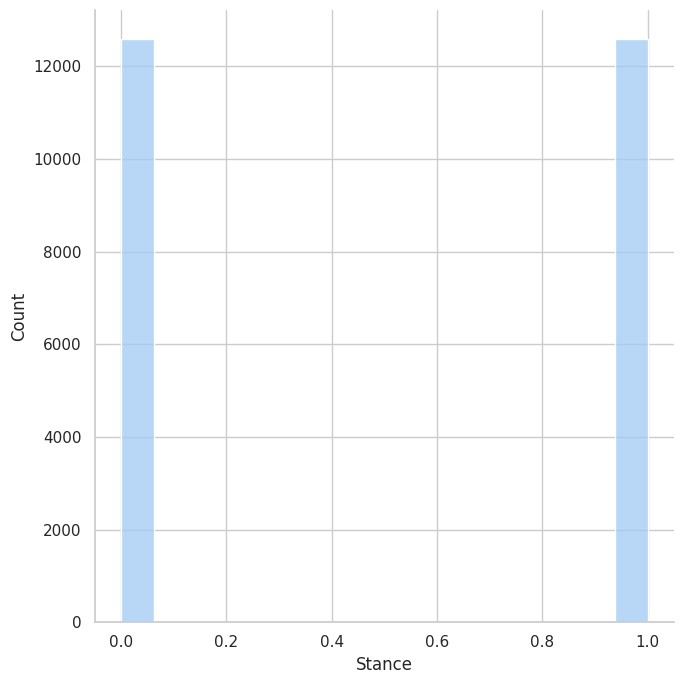

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df, x="Stance",height=7,aspect=1)

## DistilBERT test titles embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['Headline'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 12734/12734 [25:28<00:00,  8.33it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_bin.npy', labels)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

ros = RandomUnderSampler(random_state=42)
df1, df1['Stance'] = ros.fit_resample(df1, df1['Stance'])

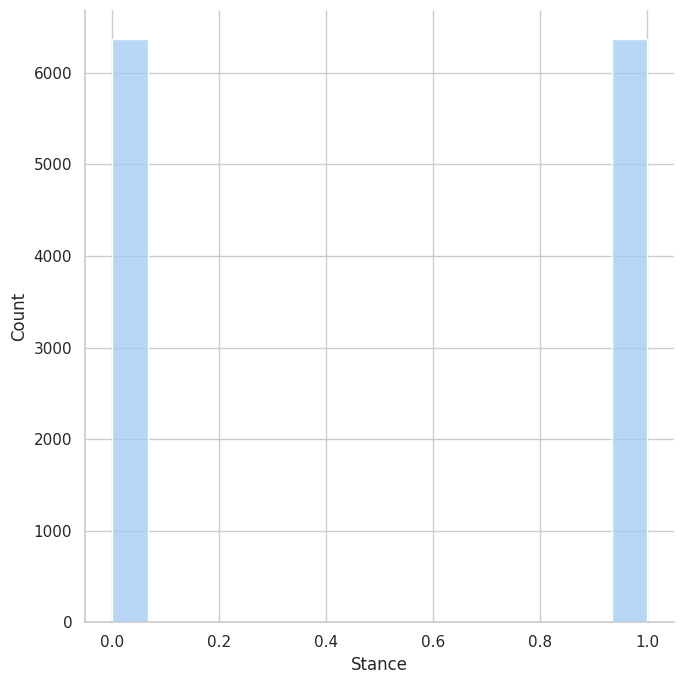

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")
sns.displot(df1, x="Stance",height=7,aspect=1)

## DistilBERT train text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:35:53<00:00,  8.69it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert_bin.npy', labels)

## DistilBERT test text embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['articleBody'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert_bin.npy', labels)

## DistilBERT train max-worth embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = titles[i:i+batch_size]
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 49972/49972 [1:36:12<00:00,  8.66it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_max_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_max_bin.npy', labels)

## DistilBERT test max-worth embeddings

In [ ]:
from tqdm import tqdm

#εφαρμόζουme τη συνάρτηση στη στήλη με τους τίτλους
batch_size = 1
titles = df1['max'].tolist()
embeddings = []

for i in tqdm(range(0, len(titles), batch_size)):
    batch_titles = str(titles[i:i+batch_size])
  
    batch_embeddings = get_embeddings(batch_titles)
    
    embeddings.append(batch_embeddings)

100%|██████████| 25413/25413 [49:34<00:00,  8.54it/s]


In [ ]:
embeddings = tf.concat(embeddings,axis=0)

In [ ]:
labels = df1['Stance'].to_numpy()

In [ ]:
np.save('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_max_bin.npy', np.array(embeddings))
np.save('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_max_bin.npy', labels)

# **CNN-DistilBERT-Titles**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=4, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/4
3124/3124 [==============================] - 29s 7ms/step - loss: 0.5712 - accuracy: 0.7481 - val_loss: 0.5627 - val_accuracy: 0.7495
Epoch 2/4
3124/3124 [==============================] - 21s 7ms/step - loss: 0.5647 - accuracy: 0.7481 - val_loss: 0.5638 - val_accuracy: 0.7495
Epoch 3/4
3124/3124 [==============================] - 19s 6ms/step - loss: 0.5623 - accuracy: 0.7481 - val_loss: 0.5715 - val_accuracy: 0.7495
Epoch 4/4
3124/3124 [==============================] - 21s 7ms/step - loss: 0.5594 - accuracy: 0.7481 - val_loss: 0.5698 - val_accuracy: 0.7495


In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.749458909034729
Test F1 Score: 0.0
Test Recall: 0.0
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 764, 128)          768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 152, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 148, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 flatten (Flatten)           (None, 3200)              0

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 2s 2ms/step
[[19046     0]
 [ 6367     0]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

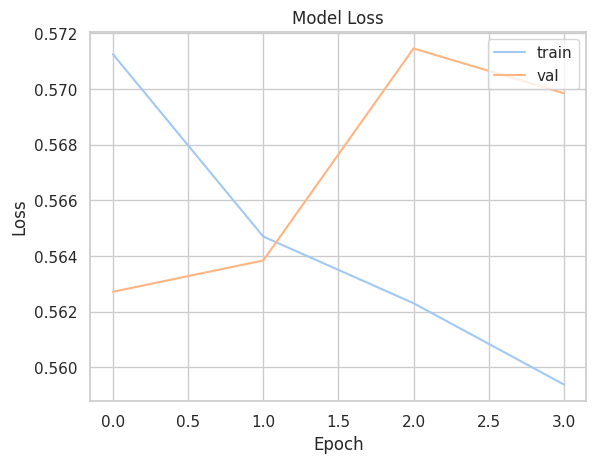

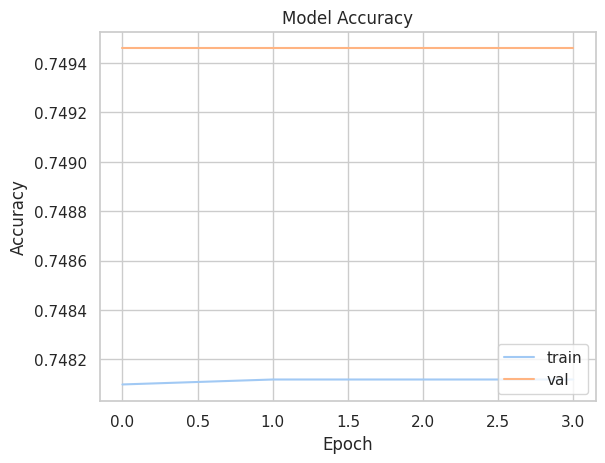

795/795 [==============================] - 2s 3ms/step


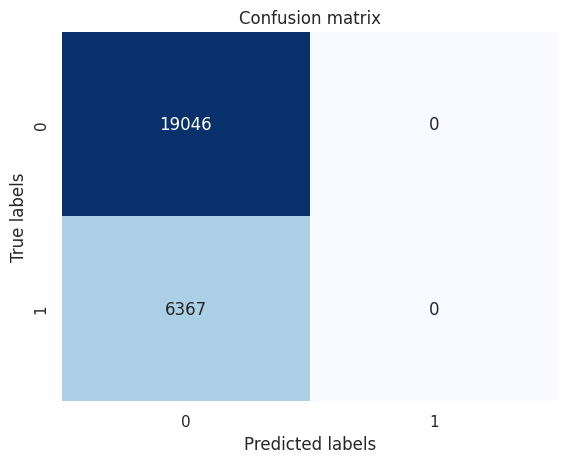

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     19046
           1       0.00      0.00      0.00      6367

    accuracy                           0.75     25413
   macro avg       0.37      0.50      0.43     25413
weighted avg       0.56      0.75      0.64     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Titles**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=5, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/5
3124/3124 [==============================] - 53s 15ms/step - loss: 0.5939 - accuracy: 0.7480 - val_loss: 0.5644 - val_accuracy: 0.7495
Epoch 2/5
3124/3124 [==============================] - 44s 14ms/step - loss: 0.5663 - accuracy: 0.7481 - val_loss: 0.5733 - val_accuracy: 0.7495
Epoch 3/5
3124/3124 [==============================] - 50s 16ms/step - loss: 0.5650 - accuracy: 0.7481 - val_loss: 0.5653 - val_accuracy: 0.7495
Epoch 4/5
3124/3124 [==============================] - 45s 14ms/step - loss: 0.5634 - accuracy: 0.7481 - val_loss: 0.5633 - val_accuracy: 0.7495
Epoch 5/5
3124/3124 [==============================] - 44s 14ms/step - loss: 0.5621 - accuracy: 0.7481 - val_loss: 0.5650 - val_accuracy: 0.7495


In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 4s - loss: 0.5650 - accuracy: 0.7495 - 4s/epoch - 5ms/step
795/795 [==============================] - 5s 5ms/step
Test Accuracy: 0.749458909034729
Test F1 Score: 0.0
Test Recall: 0.0
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 764, 64)           384       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 382, 64)          0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 378, 64)           20544     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 189, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 185, 64)           20544     
                                                                 
 lstm (LSTM)                 (None, 185, 64)          

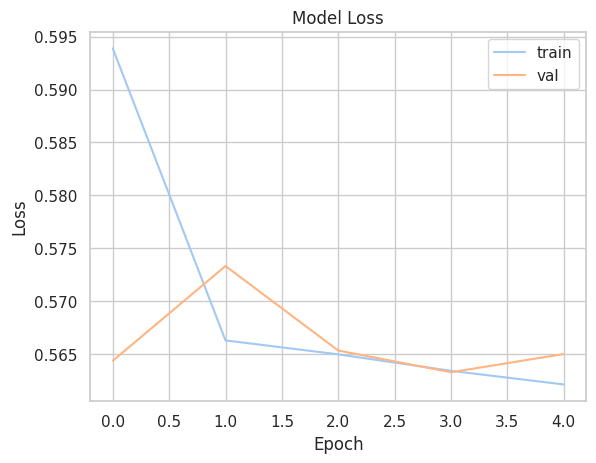

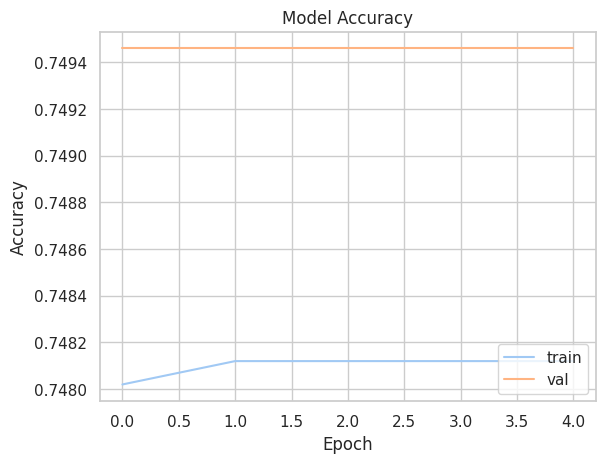

795/795 [==============================] - 4s 5ms/step


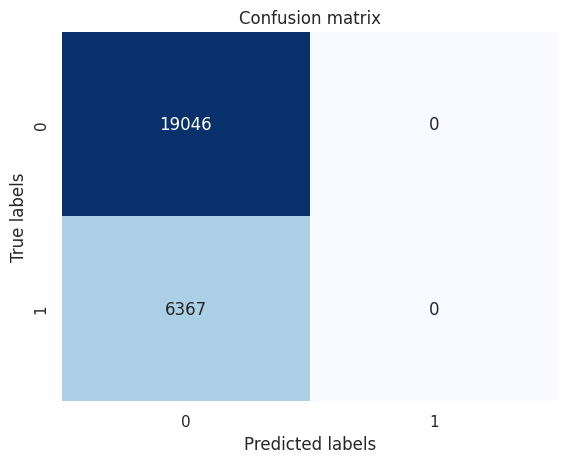

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     19046
           1       0.00      0.00      0.00      6367

    accuracy                           0.75     25413
   macro avg       0.37      0.50      0.43     25413
weighted avg       0.56      0.75      0.64     25413



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Titles**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=5, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/5
3124/3124 [==============================] - 42s 12ms/step - loss: 0.5692 - accuracy: 0.7480 - val_loss: 0.5633 - val_accuracy: 0.7495
Epoch 2/5
3124/3124 [==============================] - 42s 13ms/step - loss: 0.5656 - accuracy: 0.7481 - val_loss: 0.5630 - val_accuracy: 0.7495
Epoch 3/5
3124/3124 [==============================] - 38s 12ms/step - loss: 0.5646 - accuracy: 0.7481 - val_loss: 0.5629 - val_accuracy: 0.7495
Epoch 4/5
3124/3124 [==============================] - 42s 13ms/step - loss: 0.5649 - accuracy: 0.7481 - val_loss: 0.5636 - val_accuracy: 0.7495
Epoch 5/5
3124/3124 [==============================] - 42s 13ms/step - loss: 0.5638 - accuracy: 0.7481 - val_loss: 0.5641 - val_accuracy: 0.7495


In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 5s - loss: 0.5641 - accuracy: 0.7495 - 5s/epoch - 6ms/step
795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.749458909034729
Test F1 Score: 0.0
Test Recall: 0.0
Precision: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_6 (Conv1D)              (None, 768, 128)     512         ['input_1[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 768, 128)     640         ['input_1[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 768, 128)     768         ['input_1[0][0]']                
                                                                                              

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 4s 5ms/step
[[19046     0]
 [ 6367     0]]


# **CNN-DistilBERT-Texts**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=4, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/4
3124/3124 [==============================] - 23s 7ms/step - loss: 0.5574 - accuracy: 0.7481 - val_loss: 0.5947 - val_accuracy: 0.7495
Epoch 2/4
3124/3124 [==============================] - 21s 7ms/step - loss: 0.5342 - accuracy: 0.7494 - val_loss: 0.5748 - val_accuracy: 0.7499
Epoch 3/4
3124/3124 [==============================] - 20s 6ms/step - loss: 0.5146 - accuracy: 0.7543 - val_loss: 0.5762 - val_accuracy: 0.7334
Epoch 4/4
3124/3124 [==============================] - 21s 7ms/step - loss: 0.4963 - accuracy: 0.7647 - val_loss: 0.6132 - val_accuracy: 0.7125


In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7124699950218201
Test F1 Score: 0.14065623897447962
Test Recall: 0.09392178419978012
Precision: 0.2799625468164794


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_10 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 152, 128)         0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 29, 128)          0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 flatten_3 (Flatten)         (None, 3200)             

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 2s 2ms/step
[[17508  1538]
 [ 5769   598]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

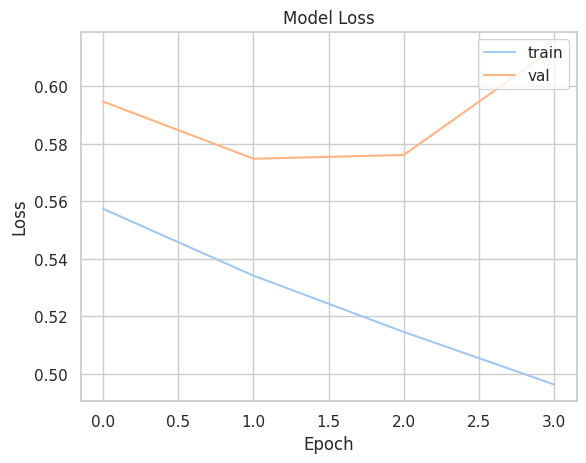

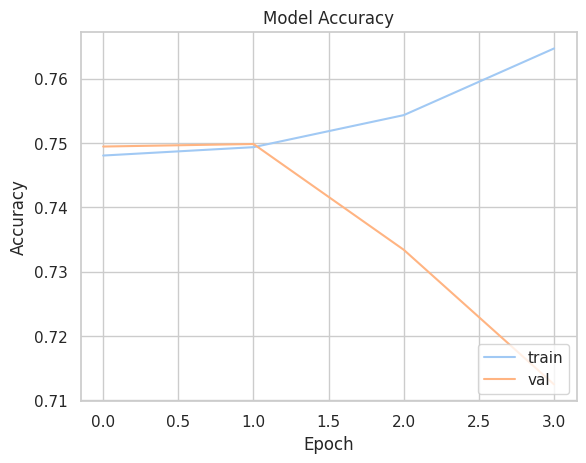

795/795 [==============================] - 2s 2ms/step


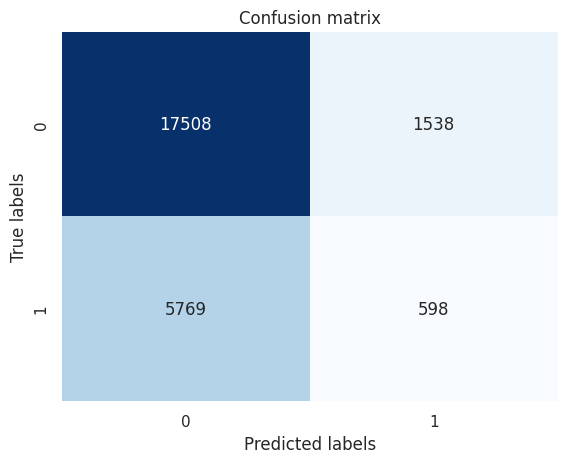

              precision    recall  f1-score   support

           0       0.75      0.92      0.83     19046
           1       0.28      0.09      0.14      6367

    accuracy                           0.71     25413
   macro avg       0.52      0.51      0.48     25413
weighted avg       0.63      0.71      0.66     25413



In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-Texts**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=5, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/5
3124/3124 [==============================] - 49s 14ms/step - loss: 0.5777 - accuracy: 0.7480 - val_loss: 0.7913 - val_accuracy: 0.7495
Epoch 2/5
3124/3124 [==============================] - 47s 15ms/step - loss: 0.5396 - accuracy: 0.7493 - val_loss: 0.5883 - val_accuracy: 0.7331
Epoch 3/5
3124/3124 [==============================] - 44s 14ms/step - loss: 0.5246 - accuracy: 0.7544 - val_loss: 1.2259 - val_accuracy: 0.7495
Epoch 4/5
3124/3124 [==============================] - 46s 15ms/step - loss: 0.5066 - accuracy: 0.7648 - val_loss: 0.6864 - val_accuracy: 0.7495
Epoch 5/5
3124/3124 [==============================] - 44s 14ms/step - loss: 0.4908 - accuracy: 0.7777 - val_loss: 0.6166 - val_accuracy: 0.7394


In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 5s - loss: 0.6166 - accuracy: 0.7394 - 5s/epoch - 6ms/step
795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.7394247055053711
Test F1 Score: 0.11847710330138445
Test Recall: 0.06989162871053871
Precision: 0.388646288209607


In [ ]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 382, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_11 (MaxPoolin  (None, 189, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm_1 (LSTM)               (None, 185, 64)          

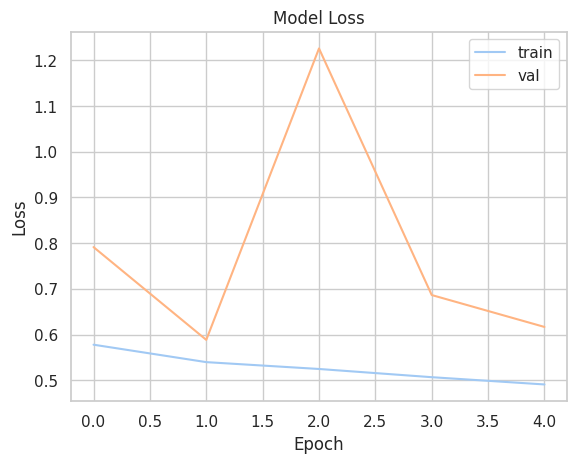

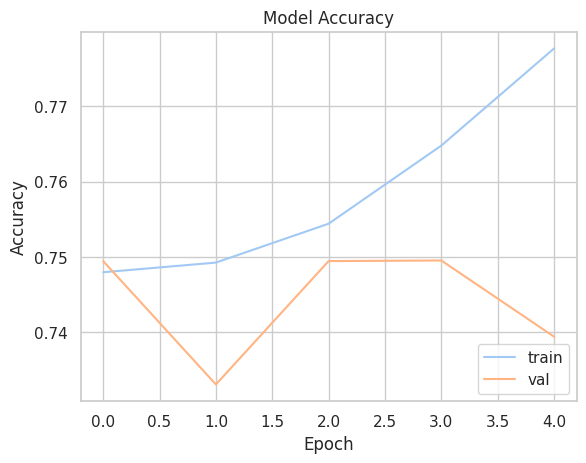

795/795 [==============================] - 4s 5ms/step


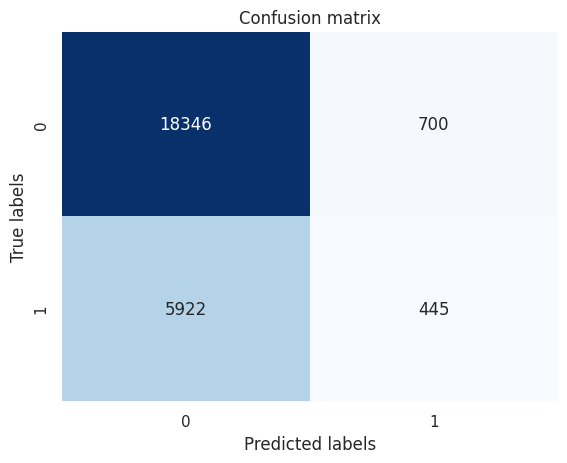

              precision    recall  f1-score   support

           0       0.76      0.96      0.85     19046
           1       0.39      0.07      0.12      6367

    accuracy                           0.74     25413
   macro avg       0.57      0.52      0.48     25413
weighted avg       0.66      0.74      0.66     25413



In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-Texts**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=5, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/5
3124/3124 [==============================] - 41s 12ms/step - loss: 0.5552 - accuracy: 0.7478 - val_loss: 0.5880 - val_accuracy: 0.7495
Epoch 2/5
3124/3124 [==============================] - 42s 13ms/step - loss: 0.5314 - accuracy: 0.7503 - val_loss: 0.5810 - val_accuracy: 0.7471
Epoch 3/5
3124/3124 [==============================] - 38s 12ms/step - loss: 0.5069 - accuracy: 0.7638 - val_loss: 0.5967 - val_accuracy: 0.7369
Epoch 4/5
3124/3124 [==============================] - 37s 12ms/step - loss: 0.4854 - accuracy: 0.7780 - val_loss: 0.6136 - val_accuracy: 0.7171
Epoch 5/5
3124/3124 [==============================] - 38s 12ms/step - loss: 0.4695 - accuracy: 0.7912 - val_loss: 0.6163 - val_accuracy: 0.7072


In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 4s - loss: 0.6163 - accuracy: 0.7072 - 4s/epoch - 5ms/step
795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.7072364687919617
Test F1 Score: 0.14893617021276595
Test Recall: 0.10224595570912517
Precision: 0.27410526315789474


In [ ]:
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_16 (Conv1D)             (None, 768, 128)     512         ['input_2[0][0]']                
                                                                                                  
 conv1d_17 (Conv1D)             (None, 768, 128)     640         ['input_2[0][0]']                
                                                                                                  
 conv1d_18 (Conv1D)             (None, 768, 128)     768         ['input_2[0][0]']                
                                                                                            

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 4s 5ms/step
[[17322  1724]
 [ 5716   651]]


# **CNN-DistilBERT-MaxWorth**

In [ ]:
#εισάγουμε τα δεδομένα από τ' αποθηκευμένα αρχεία που δημιουργήσαμε νωρίτερα
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_max_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_max_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_max_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_max_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
# build the model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(768,1)))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1 = model.fit(train_embeddings, train_labels, epochs=4, batch_size=16,validation_data=(test_embeddings, test_labels))

Epoch 1/4
3124/3124 [==============================] - 23s 7ms/step - loss: 0.5598 - accuracy: 0.7480 - val_loss: 0.5824 - val_accuracy: 0.7495
Epoch 2/4
3124/3124 [==============================] - 21s 7ms/step - loss: 0.5385 - accuracy: 0.7490 - val_loss: 0.5685 - val_accuracy: 0.7495
Epoch 3/4
3124/3124 [==============================] - 20s 6ms/step - loss: 0.5193 - accuracy: 0.7552 - val_loss: 0.5858 - val_accuracy: 0.7480
Epoch 4/4
3124/3124 [==============================] - 21s 7ms/step - loss: 0.4982 - accuracy: 0.7667 - val_loss: 0.5938 - val_accuracy: 0.7466


In [ ]:
test_loss, test_acc = model.evaluate(test_embeddings, test_labels)

y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

#accuraccy 
print("Test Accuracy:", test_acc)
#f1-score
print("Test F1 Score:", f1)
#recall
print("Test Recall:", recall)
#precision
print("Precision:", precision)

795/795 [==============================] - 2s 2ms/step
Test Accuracy: 0.7466257214546204
Test F1 Score: 0.007399414213041468
Test Recall: 0.0037694361551751216
Precision: 0.2


In [ ]:
#λεπτομέρειες για τη δομή του μοντέλου
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 764, 128)          768       
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 152, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, 148, 128)          82048     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 29, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 25, 128)           82048     
                                                                 
 flatten_6 (Flatten)         (None, 3200)             

In [ ]:
y_pred = model.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 2s 2ms/step
[[18950    96]
 [ 6343    24]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
def plot_history(history,model):
   # Plot training and validation loss
    sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()
    
    # Plot training and validation accuracy
    sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
    sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.show()

    y_pred = model.predict(test_embeddings)
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(test_labels, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion matrix')
    plt.show()
    
    # Print the classification report
    print(classification_report(test_labels, y_pred))

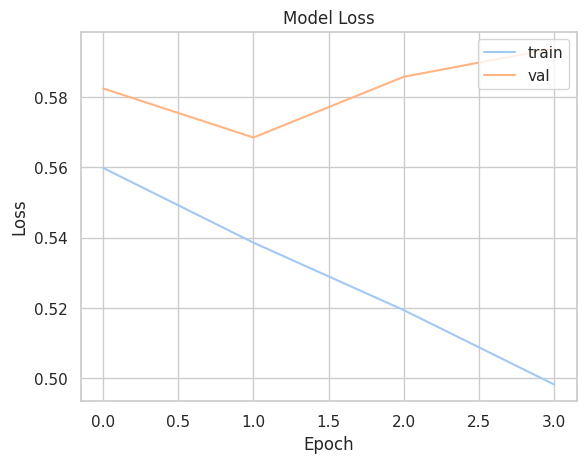

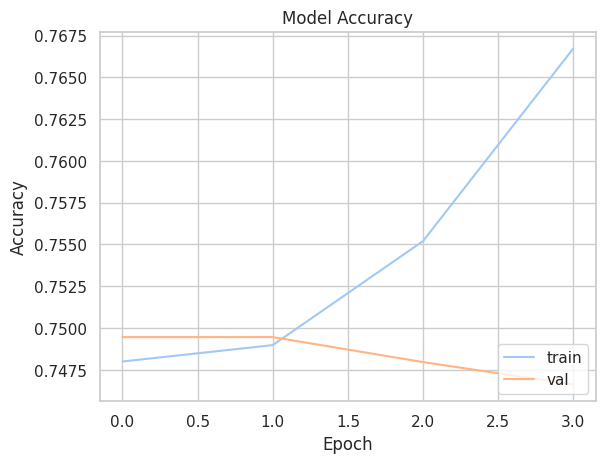

795/795 [==============================] - 2s 3ms/step


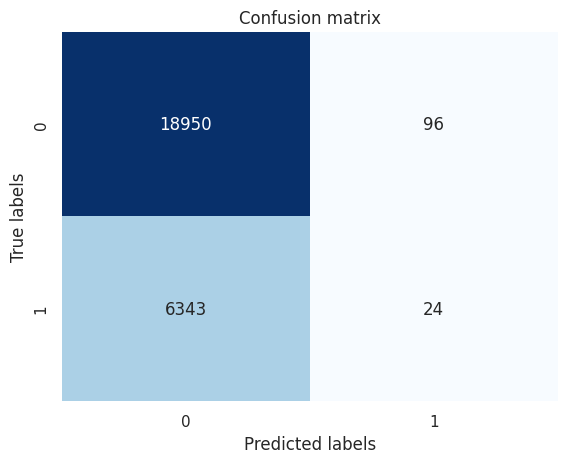

              precision    recall  f1-score   support

           0       0.75      0.99      0.85     19046
           1       0.20      0.00      0.01      6367

    accuracy                           0.75     25413
   macro avg       0.47      0.50      0.43     25413
weighted avg       0.61      0.75      0.64     25413



In [ ]:
plot_history(history1,model)

# **LSTM-DistilBERT-MaxWorth**

In [ ]:
model2 = Sequential()
model2.add(Conv1D(64, 5, activation='relu', input_shape=(768, 1)))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(MaxPooling1D(pool_size=2))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history2 = model2.fit(train_embeddings, train_labels, epochs=5, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/5
3124/3124 [==============================] - 50s 15ms/step - loss: 0.5818 - accuracy: 0.7480 - val_loss: 1.2653 - val_accuracy: 0.7495
Epoch 2/5
3124/3124 [==============================] - 47s 15ms/step - loss: 0.5392 - accuracy: 0.7502 - val_loss: 0.5948 - val_accuracy: 0.7434
Epoch 3/5
3124/3124 [==============================] - 47s 15ms/step - loss: 0.5181 - accuracy: 0.7588 - val_loss: 0.5847 - val_accuracy: 0.7394
Epoch 4/5
3124/3124 [==============================] - 45s 15ms/step - loss: 0.4973 - accuracy: 0.7704 - val_loss: 0.6006 - val_accuracy: 0.7333
Epoch 5/5
3124/3124 [==============================] - 45s 15ms/step - loss: 0.4800 - accuracy: 0.7831 - val_loss: 0.6564 - val_accuracy: 0.7175


In [ ]:
test_loss, test_acc = model2.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model2.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 4s - loss: 0.6564 - accuracy: 0.7175 - 4s/epoch - 6ms/step
795/795 [==============================] - 5s 5ms/step
Test Accuracy: 0.7174674272537231
Test F1 Score: 0.07664609053497942
Test Recall: 0.0468038322600911
Precision: 0.21149751596877217


In [ ]:
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_23 (Conv1D)          (None, 764, 64)           384       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 382, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_24 (Conv1D)          (None, 378, 64)           20544     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 189, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 185, 64)           20544     
                                                                 
 lstm_2 (LSTM)               (None, 185, 64)          

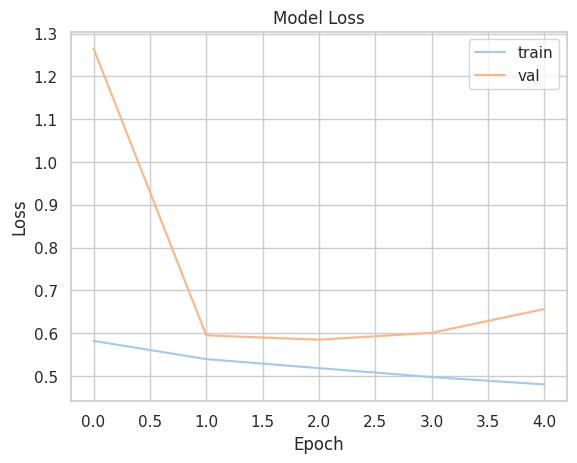

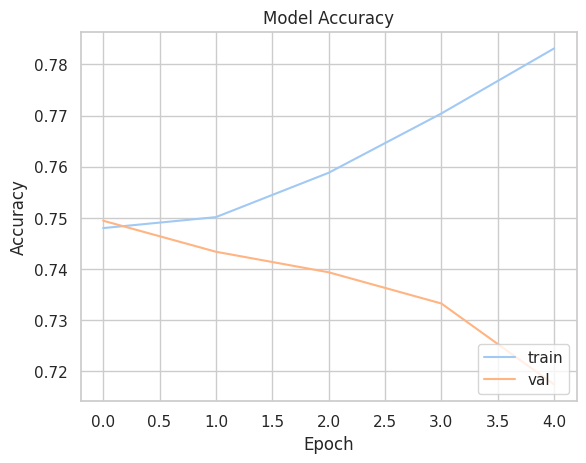

795/795 [==============================] - 4s 5ms/step


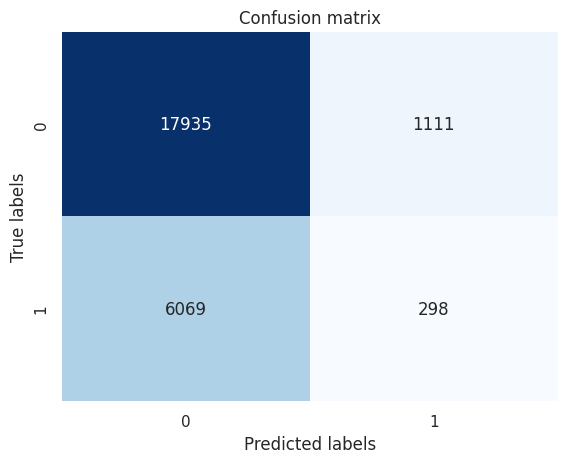

              precision    recall  f1-score   support

           0       0.75      0.94      0.83     19046
           1       0.21      0.05      0.08      6367

    accuracy                           0.72     25413
   macro avg       0.48      0.49      0.45     25413
weighted avg       0.61      0.72      0.64     25413



In [ ]:
plot_history(history2,model2)

# **FakeBert-DistilBERT-MaxWorth**

In [ ]:
inputs = Input(shape=(768, 1))
conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
maxpool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(128, 4, activation='relu', padding='same')(inputs)
maxpool2 = MaxPooling1D(pool_size=2)(conv2)
conv3 = Conv1D(128, 5, activation='relu', padding='same')(inputs)
maxpool3 = MaxPooling1D(pool_size=2)(conv3)
concat = Concatenate()([maxpool1, maxpool2, maxpool3])
conv4 = Conv1D(128, 5, activation='relu', padding='same')(concat)
maxpool4 = MaxPooling1D(pool_size=2)(conv4)
flatten = Flatten()(maxpool4)
dense1 = Dense(384, activation='relu')(flatten)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(1, activation='sigmoid')(dropout2)

model3 = Model(inputs=inputs, outputs=output)

In [ ]:
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history3 = model3.fit(train_embeddings, train_labels, epochs=5, batch_size=16, validation_data=(test_embeddings, test_labels))

Epoch 1/5
3124/3124 [==============================] - 42s 12ms/step - loss: 0.5535 - accuracy: 0.7478 - val_loss: 0.5670 - val_accuracy: 0.7495
Epoch 2/5
3124/3124 [==============================] - 38s 12ms/step - loss: 0.5211 - accuracy: 0.7575 - val_loss: 0.6335 - val_accuracy: 0.7408
Epoch 3/5
3124/3124 [==============================] - 42s 13ms/step - loss: 0.4874 - accuracy: 0.7782 - val_loss: 0.6027 - val_accuracy: 0.7148
Epoch 4/5
3124/3124 [==============================] - 37s 12ms/step - loss: 0.4611 - accuracy: 0.7956 - val_loss: 0.6070 - val_accuracy: 0.7103
Epoch 5/5
3124/3124 [==============================] - 42s 13ms/step - loss: 0.4444 - accuracy: 0.8064 - val_loss: 0.6148 - val_accuracy: 0.7172


In [ ]:
test_loss, test_acc = model3.evaluate(test_embeddings, test_labels, verbose=2)

y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 4s - loss: 0.6148 - accuracy: 0.7172 - 4s/epoch - 6ms/step
795/795 [==============================] - 4s 5ms/step
Test Accuracy: 0.7171526551246643
Test F1 Score: 0.13957385683504905
Test Recall: 0.09156588660279566
Precision: 0.2934071464519376


In [ ]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 768, 1)]     0           []                               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 768, 128)     512         ['input_3[0][0]']                
                                                                                                  
 conv1d_27 (Conv1D)             (None, 768, 128)     640         ['input_3[0][0]']                
                                                                                                  
 conv1d_28 (Conv1D)             (None, 768, 128)     768         ['input_3[0][0]']                
                                                                                            

In [ ]:
y_pred = model3.predict(test_embeddings)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 4s 5ms/step
[[17642  1404]
 [ 5784   583]]


# **DistilBERT-Text-Title**

In [ ]:
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_distilbert_bin.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_distilbert_bin.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_distilbert_bin.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_distilbert_bin.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5567 - accuracy: 0.7474
Epoch 2/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5428 - accuracy: 0.7506
Epoch 3/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5344 - accuracy: 0.7532
Epoch 4/9
3124/3124 [==============================] - 11s 4ms/step - loss: 0.5275 - accuracy: 0.7561
Epoch 5/9
3124/3124 [==============================] - 11s 3ms/step - loss: 0.5219 - accuracy: 0.7595
Epoch 6/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5159 - accuracy: 0.7612
Epoch 7/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5098 - accuracy: 0.7646
Epoch 8/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5047 - accuracy: 0.7665
Epoch 9/9
3124/3124 [==============================] - 10s 3ms/step - loss: 0.5026 - accuracy: 0.7694


In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 2s - loss: 0.6042 - accuracy: 0.7249 - 2s/epoch - 3ms/step
795/795 [==============================] - 1s 2ms/step
Test Accuracy: 0.7249045968055725
Test F1 Score: 0.0926670992861778
Test Recall: 0.05607036280822993
Precision: 0.26681614349775784


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_21 (Dense)               (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_21[0][0]',         

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 1s 2ms/step
[[18065   981]
 [ 6010   357]]


# **DistilBERT-Max Worth-Title**

In [ ]:
train_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_title_distilbert_bin.npy')
train_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_title_distilbert_bin.npy')
test_embeddings = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_title_distilbert_bin.npy')
test_labels = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_title_distilbert_bin.npy')

In [ ]:
train_embeddings = tf.expand_dims(train_embeddings, axis=-1)
test_embeddings = tf.expand_dims(test_embeddings, axis=-1)

In [ ]:
train_embeddings.shape

TensorShape([49972, 768, 1])

In [ ]:
train_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_train_text_max_bin.npy')
train_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_train_text_max_bin.npy')
test_embeddings1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/embeddings_test_text_max_bin.npy')
test_labels1 = np.load('/content/drive/MyDrive/FakeNewsChallenge/labels_test_text_max_bin.npy')

In [ ]:
train_embeddings1 = tf.expand_dims(train_embeddings1, axis=-1)
test_embeddings1 = tf.expand_dims(test_embeddings1, axis=-1)

In [ ]:
train_embeddings1.shape

TensorShape([49972, 768, 1])

In [ ]:
title_input = Input(shape=(768,), name='title_bert')
text_input = Input(shape=(768,), name='text_bert')
shared_dense = Dense(768, activation='relu')
title_output = shared_dense(title_input)
text_output = shared_dense(text_input)
concatenated = Concatenate(axis=1, name='concatenated')([title_output, text_output])
dropped_out = Dropout(0.5)(concatenated)
output = Dense(1, activation='sigmoid', name='output')(dropped_out)
model = Model(inputs=[title_input, text_input], outputs=output)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=[tf.squeeze(train_embeddings), tf.squeeze(train_embeddings1)],
          y=train_labels,
          epochs=9,
          batch_size=16)

Epoch 1/9
3124/3124 [==============================] - 13s 4ms/step - loss: 0.5574 - accuracy: 0.7472
Epoch 2/9
3124/3124 [==============================] - 11s 4ms/step - loss: 0.5427 - accuracy: 0.7499
Epoch 3/9
3124/3124 [==============================] - 11s 3ms/step - loss: 0.5334 - accuracy: 0.7550
Epoch 4/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5258 - accuracy: 0.7575
Epoch 5/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5194 - accuracy: 0.7608
Epoch 6/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.5133 - accuracy: 0.7628
Epoch 7/9
3124/3124 [==============================] - 10s 3ms/step - loss: 0.5074 - accuracy: 0.7647
Epoch 8/9
3124/3124 [==============================] - 11s 4ms/step - loss: 0.5019 - accuracy: 0.7691
Epoch 9/9
3124/3124 [==============================] - 12s 4ms/step - loss: 0.4979 - accuracy: 0.7705


In [ ]:
test_loss, test_acc = model.evaluate([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)], test_labels, verbose=2)

y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype('int32')

f1 = f1_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)

print("Test Accuracy:", test_acc)
print("Test F1 Score:", f1)
print("Test Recall:", recall)
print("Precision:", precision)

795/795 - 2s - loss: 0.5843 - accuracy: 0.7418 - 2s/epoch - 2ms/step
795/795 [==============================] - 1s 2ms/step
Test Accuracy: 0.7417857050895691
Test F1 Score: 0.05091119467746601
Test Recall: 0.027642531804617558
Precision: 0.3217550274223035


In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 title_bert (InputLayer)        [(None, 768)]        0           []                               
                                                                                                  
 text_bert (InputLayer)         [(None, 768)]        0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 768)          590592      ['title_bert[0][0]',             
                                                                  'text_bert[0][0]']              
                                                                                                  
 concatenated (Concatenate)     (None, 1536)         0           ['dense_22[0][0]',         

In [ ]:
y_pred = model.predict([tf.squeeze(test_embeddings),tf.squeeze(test_embeddings1)])
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(test_labels, y_pred)
print(cm)

795/795 [==============================] - 1s 2ms/step
[[18675   371]
 [ 6191   176]]
